**Install dependencies**

In [ ]:
# %%capture
# !pip install -U torch torchvision torchaudio
# !pip install numpy pandas pillow
# !pip install -U cjm_pil_utils cjm_pytorch_utils

**Import dependencies**

In [ ]:
from pathlib import Path
import random

from PIL import Image
import numpy as np
import timm
from tqdm.auto import tqdm
import gradio as gr

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
from torchvision import transforms, models

# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, get_torch_device

**Set device and data type**

In [ ]:
device = get_torch_device()
dtype = torch.float16 if device == 'cuda' else torch.float32
device, dtype

('cuda', torch.float16)

In [ ]:
dtype = torch.float32

**Enter Kaggle username and API token**

In [ ]:
username = ""
key = ""

**Save Kaggle credentials to file**

In [ ]:
save_kaggle_creds(username, key, overwrite=False)

Empty username.


**Define directory paths**

In [ ]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


**Define Kaggle dataset**

In [ ]:
# Set the name of the dataset
dataset_name = 'hagrid-classification-512p-no-gesture-150k'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/hagrid-classification-512p-no-gesture-150k.zip
Dataset Path: /mnt/980_1TB_2/Datasets/hagrid-classification-512p-no-gesture-150k


**Download Kaggle dataset**

In [ ]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

Dataset already downloaded


**Get image classes**

In [ ]:
# Get all subfolders within the dataset_path
folders = [folder for folder in dataset_path.glob('*/') if folder.is_dir()]

# Store the folder names
class_names = [f.name for f in folders]

# Print the list of class names
pd.DataFrame(class_names)

,0
0,call
1,dislike
2,fist
3,four
4,like
5,mute
6,no_gesture
7,ok
8,one
9,palm


**Get image paths**

In [ ]:
# Get a list of all image file paths from the given folders
img_paths = [get_img_files(folder) for folder in folders]

# Flatten the list of lists into a single list
img_paths = [path for class_paths in img_paths for path in class_paths]

# Get the number of image file paths
len(img_paths)

153735

**Display sample image**

Class: ok


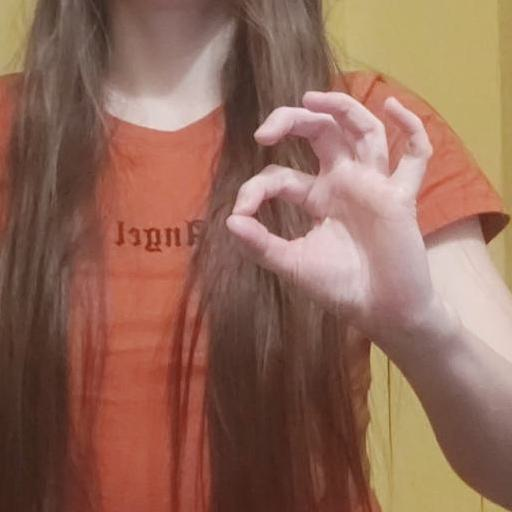

In [ ]:
# Select a random image path from the list of image paths
img_path = random.choice(img_paths)

# Print the name of the class of the image, which is the name of the parent folder
print(f"Class: {img_path.parent.name}")

# Open the image using the path
sample_img = Image.open(img_path)

# Display the image
sample_img

**Set training and validation sets**

In [ ]:
# img_paths_subset = random.sample(img_paths, 70000)
img_paths_subset = random.sample(img_paths, len(img_paths))

**List available ResNet18 models**

In [ ]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

,0
0,resnet18
1,resnet18d


**Inspect config for ResNet18 model**

In [ ]:
# Import the convnext module
from timm.models import resnet

# Choose the resnet model
resnet_model = 'resnet18d'

# Get the default configuration of the chosen model as a Pandas DataFrame
pd.DataFrame.from_dict(resnet.default_cfgs[resnet_model], orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth
num_classes,1000
input_size,"(3, 224, 224)"
pool_size,"(7, 7)"
crop_pct,0.875
interpolation,bicubic
mean,"(0.485, 0.456, 0.406)"
std,"(0.229, 0.224, 0.225)"
first_conv,conv1.0
classifier,fc


**Load ResNet18 model**

In [ ]:
# Load the resenet model
resnet18 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type
resnet18 = resnet18.to(device=device, dtype=dtype).eval()
resnet18.device = device

**Select model**

In [ ]:
model = resnet18

**Set normalization stats**

In [ ]:
norm_stats = resnet.default_cfgs[resnet_model]['mean'], resnet.default_cfgs[resnet_model]['std']
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

**Set checkpoint directory**

In [ ]:
# Create a directory to store the checkpoints if it does not already exist
# checkpoint_dir = Path("./miniai_data_augmentation_seed-1/")
# checkpoint_dir = Path("./miniai_data_augmentation_seed-42/")
checkpoint_dir = Path("./miniai_data_augmentation_seed-100/")
# checkpoint_dir = Path("./miniai_data_augmentation_seed-1234/")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Print the checkpoint path
checkpoint_dir

PosixPath('miniai_data_augmentation_seed-100')

**Set checkpoint path**

In [ ]:
# checkpoint_path = checkpoint_dir/"resnet18d-baseline.pth"
# checkpoint_path = checkpoint_dir/"resnet18d-rand-square-cp-1.pth"
# checkpoint_path = checkpoint_dir/"resnet18d-rand-pixel-cp-1.pth"
# checkpoint_path = checkpoint_dir/"resnet18d-rand-square-pixel-cp-1.pth"
checkpoint_path = checkpoint_dir/"resnet18d-trivial-aug-item-1.pth"
# checkpoint_path = checkpoint_dir/"resnet18d-custom-trivial-aug-1.pth"
checkpoint_path

PosixPath('miniai_data_augmentation_seed-100/resnet18d-trivial-aug-item-1.pth')

**Load model checkpoint**

In [ ]:
model.load_state_dict(torch.load(checkpoint_path));

In [ ]:
inp_tensor = torch.randn(resnet.default_cfgs[resnet_model]['input_size'])[None]
inp_tensor.shape

torch.Size([1, 3, 224, 224])

**Set values for exporting the model to ONNX**

In [ ]:
opset_version = 12
export_dtype = dtype
export_dtype_str = f"{export_dtype}".split('.')[-1]

**Define save path for ONNX model**

In [ ]:
onnx_file_path = Path(checkpoint_dir/f"{checkpoint_path.stem}-opset-{opset_version}-{export_dtype_str}.onnx")
onnx_file_path

PosixPath('miniai_data_augmentation_seed-100/resnet18d-trivial-aug-item-1-opset-12-float32.onnx')

**Export model to ONNX**

In [ ]:
torch.onnx.export(model.to(device=device, dtype=export_dtype),
                  inp_tensor.to(device=device, dtype=export_dtype),
                  onnx_file_path,
                  export_params=True,
                  opset_version=opset_version,
                  do_constant_folding=False
                 )

**Export class labels**

In [ ]:
class_labels = {"classes": class_names}
class_labels_file_name = f"{dataset_path.name}-classes.json"
class_labels_file_name

'hagrid-classification-512p-no-gesture-150k-classes.json'

In [ ]:
import json

with open(class_labels_file_name, "w") as write_file:
    json.dump(class_labels, write_file)